In [29]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import time
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
%matplotlib inline
# from keras.models import Sequential
# from keras.layers import Dense

In [30]:
random_state = 42
np.random.seed(seed=random_state)

## Gini metric

In [31]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

def gini_lgb(preds, dtrain):
    y = list(dtrain.get_label())
    score = gini(y, preds) / gini(y, y)
    return 'gini', score, True

## Read input data

In [32]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

### Reduce number of records to quicken learning performance (bad idea)

In [33]:
# train, _ = train_test_split(train, train_size=0.1, stratify=train['target'], random_state=random_state)
# test, _ = train_test_split(test, train_size=0.1)
# train = train.reset_index()
# test = test.reset_index()

In [34]:
train_el_num = len(train) 
y_train_all = train['target'].values   
y_train_series = train['target']                               
id_test = test['id']                                           
train.drop(['id', 'target'], axis = 1, inplace = True)         
test.drop(['id'], axis = 1, inplace = True)                    
trainCatTest = pd.concat([train, test], axis=0) 

## Remove useless features

### Remove features with too many nulls 

In [35]:
too_many_null_cols = trainCatTest.columns[(trainCatTest.isnull().sum() > (len(trainCatTest) * 0.3)).values].values
if len(too_many_null_cols) > 0:
    trainCatTest = trainCatTest.drop(too_many_null_cols, axis=1)

In [36]:
def change_datatype(df):
    float_cols = list(df.select_dtypes(include=['int']).columns)
    for col in float_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)
            
def change_datatype_float(df):
    float_cols = list(df.select_dtypes(include=['float']).columns)
    for col in float_cols:
        df[col] = df[col].astype(np.float32)
        
change_datatype(trainCatTest)
change_datatype_float(trainCatTest)

In [37]:
# corrs_with_target = abs(train.corrwith(y_train_series)).sort_values(ascending=False)
# drop_cols = train.columns[(corrs_with_target < 0.01).values].values
# train.drop(drop_cols, axis = 1, inplace = True)

### Remove binary features

In [38]:
# bin_cols = [col for col in trainCatTest.columns if '_bin' in col]
# one_category_ratio_min = 0.05
# data_len = len(trainCatTest)
# bin_dif = abs(((trainCatTest[bin_cols] == 0).sum() - (trainCatTest[bin_cols] == 1).sum()))
# too_little_bin_cat = ((1-one_category_ratio_min) * data_len < bin_dif).values
# print(too_little_bin_cat)
# too_little_bin_cat_cols = pd.Series(bin_cols)[too_little_bin_cat]
# print(too_little_bin_cat_cols)
# trainCatTest = trainCatTest.drop(too_little_bin_cat_cols, axis=1)

### Remove categorical features

In [39]:
# cat_cols = [col for col in trainCatTest.columns if '_cat' in col]
# too_many_els_in_cat = []
# for col in trainCatTest.columns:
#     category_elements_counts = trainCatTest[col].value_counts()
#     too_many_els_in_cat.append((category_elements_counts > data_len * 0.95).any())
# trainCatTest = trainCatTest.drop(trainCatTest.columns[too_many_els_in_cat], axis=1)

## Process values

In [40]:
cat_cols = [col for col in trainCatTest.columns if '_cat' in col]
bin_cols = [col for col in trainCatTest.columns if '_bin' in col]

for col in cat_cols:
    trainCatTest[col].fillna(value = trainCatTest[col].mode()[0], inplace=True)
    
for col in bin_cols:
    trainCatTest[col].fillna(value = trainCatTest[col].mode()[0], inplace=True)

for col in cat_cols:
    temp = pd.get_dummies(pd.Series(trainCatTest[col]), prefix = col)
    trainCatTest = pd.concat([trainCatTest, temp], axis=1)
    trainCatTest = trainCatTest.drop([col], axis=1)

## Split data back to train and test

In [41]:
column_names = trainCatTest.columns
X_train_all = trainCatTest.iloc[:train_el_num]
y_train = y_train_all[:train_el_num]
X_test = trainCatTest.iloc[train_el_num:]

## Prepare parameters for fitting

In [42]:
kfold=10 # increase it
n_rounds=2000 # increase it
early_stopping_rounds=100
verbose_eval=100
skf = StratifiedKFold(n_splits=kfold, random_state=random_state)
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'silent': True,
    'tree_method': 'gpu_hist'
}
xgb_params_grid = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}
lgb_params = {
    'metric': 'auc', 
    'learning_rate': 0.05, 
    'max_depth': 10, 
    'max_bin': 10,  
    'objective': 'binary', 
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 10, 
    'min_data': 500}

# Fit

## XGB without hyperopt

In [43]:
%%time
sub_xgb = pd.DataFrame()
sub_xgb['id'] = id_test
sub_xgb['target'] = np.zeros_like(id_test)
for i, (train_index, test_index) in enumerate(skf.split(X_train_all, y_train_all)):
    print('XGB fold %d/%d' % (i + 1, kfold))
    X_train, X_valid = X_train_all.iloc[train_index], X_train_all.iloc[test_index]
    y_train, y_valid = y_train_all[train_index], y_train_all[test_index]
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    d_test = xgb.DMatrix(X_test)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model = xgb.train(xgb_params, d_train, n_rounds, watchlist, early_stopping_rounds=early_stopping_rounds, 
                    feval=gini_xgb, maximize=True, verbose_eval=verbose_eval)
    p_test = xgb_model.predict(d_test)
    sub_xgb['target'] += p_test/kfold
sub_xgb.to_csv('sub_xgb.csv',index=False)

XGB fold 1/10
[0]	train-auc:0.606463	valid-auc:0.617612	train-gini:0.212863	valid-gini:0.236741
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-auc:0.653253	valid-auc:0.647366	train-gini:0.306507	valid-gini:0.294732
[200]	train-auc:0.677083	valid-auc:0.648953	train-gini:0.354167	valid-gini:0.297905
[300]	train-auc:0.694525	valid-auc:0.648649	train-gini:0.38905	valid-gini:0.297299
Stopping. Best iteration:
[252]	train-auc:0.686193	valid-auc:0.650145	train-gini:0.372386	valid-gini:0.30029

XGB fold 2/10
[0]	train-auc:0.608288	valid-auc:0.601459	train-gini:0.216183	valid-gini:0.205468
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[100]	train-auc:0.654362	valid-auc:0.626327	train-gini:0.308724	valid-gini:0.252654
[200]	train-auc:0.678088	valid-auc:0.633504	train-gini:0.356176	valid-g

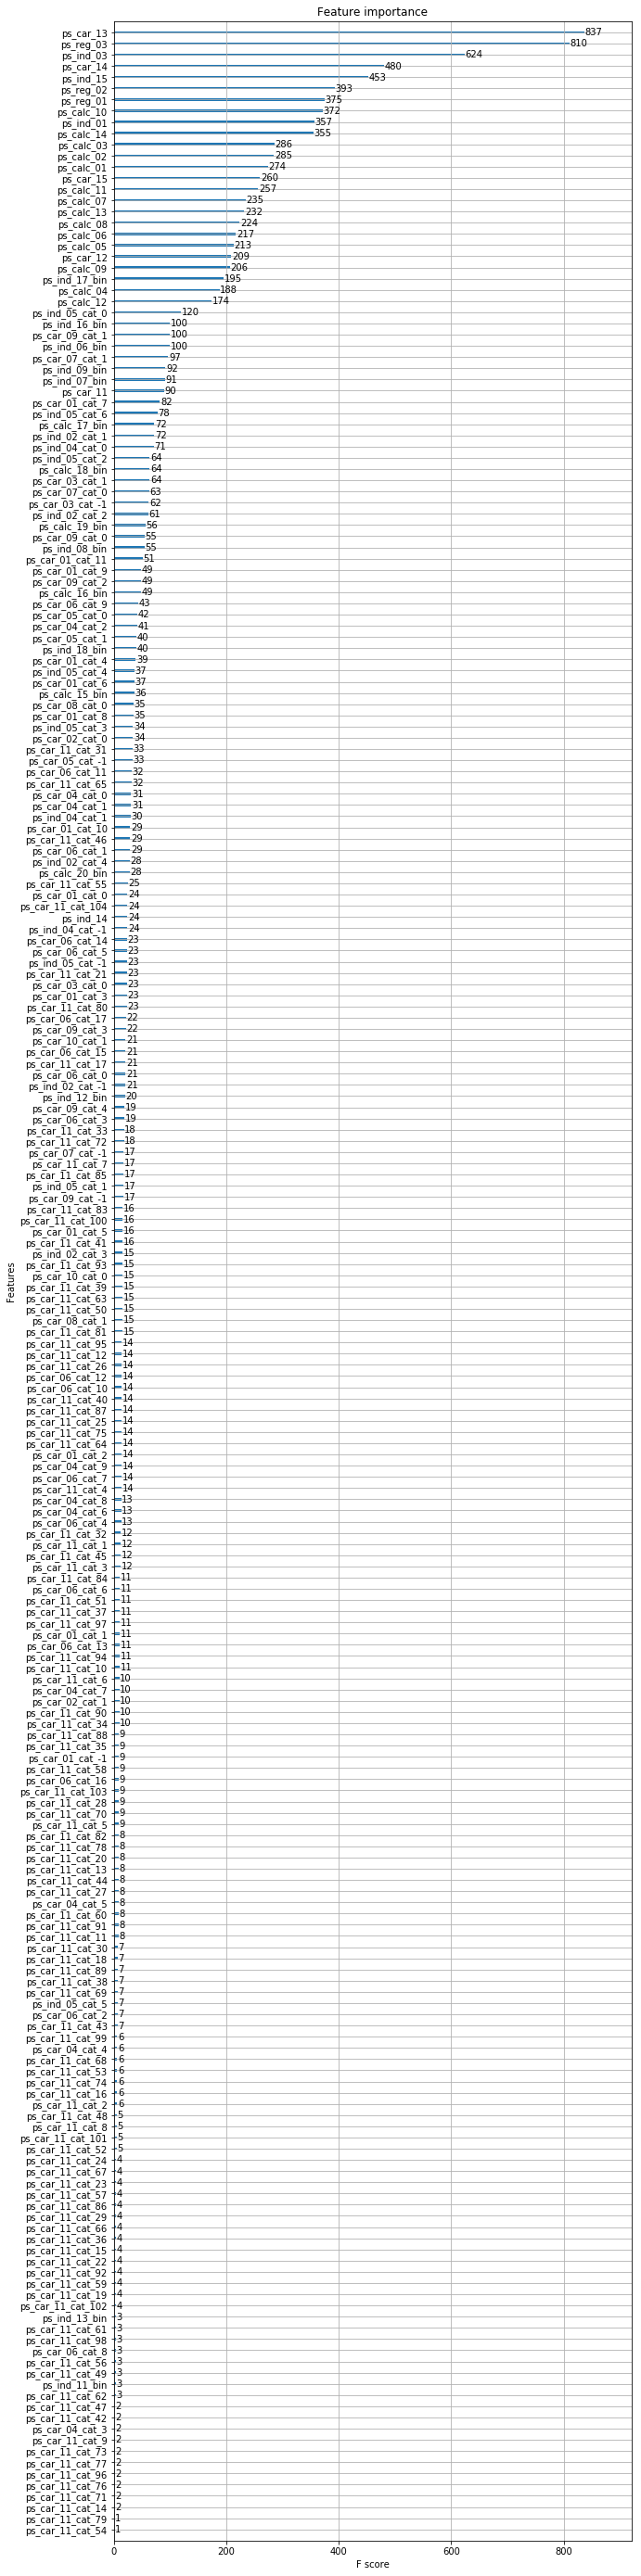

In [44]:
plt.rcParams["figure.figsize"] = (10,50)
xgb.plot_importance(xgb_model) 

In [45]:
xgb.to_graphviz(xgb_model, num_trees=0)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

## XGB with hyperopt

In [46]:
# classifier_params = {
#     'learning_rate': 0.02,
#     'n_estimators': 600,
#     'objective': 'binary:logistic',
#     'silent': Fal,
#     'nthread': 1,
#     'tree_method': 'gpu_hist'
# }
# xgb_model = xgb.XGBClassifier(classifier_params)
# param_comb = 5
# random_search = RandomizedSearchCV(xgb_model, param_distributions=xgb_params_grid, 
#                                    n_iter=param_comb, scoring='roc_auc', n_jobs=4, 
#                                    cv=skf.split(X_train_all, y_train_all), 
#                                    verbose=3, random_state=random_state)
# random_search.fit(X_train_all, y_train_all)

# print('\n All results:')
# print(random_search.cv_results_)
# print('\n Best estimator:')
# print(random_search.best_estimator_)
# print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
# print(random_search.best_score_ * 2 - 1)
# print('\n Best hyperparameters:')
# print(random_search.best_params_)
# results = pd.DataFrame(random_search.cv_results_)


## LGB

In [47]:
%%time
sub_lgb = pd.DataFrame()
sub_lgb['id'] = id_test
sub_lgb['target'] = np.zeros_like(id_test)
evals_result = {}  # to record eval results for plotting
learning_rates = np.linspace(lgb_params['learning_rate'], 0.01, n_rounds).tolist()
for i, (train_index, test_index) in enumerate(skf.split(X_train_all, y_train_all)):
    print('LGB fold %d/%d' % (i + 1, kfold))
    X_train, X_valid = X_train_all.iloc[train_index], X_train_all.iloc[test_index]
    y_train, y_valid = y_train_all[train_index], y_train_all[test_index]
    gbm = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), n_rounds, 
                          lgb.Dataset(X_valid, label=y_valid), 
                          early_stopping_rounds=early_stopping_rounds, 
                          feval=gini_lgb, verbose_eval=verbose_eval,
                          evals_result=evals_result,
                          callbacks = [lgb.reset_parameter(learning_rate=learning_rates)])
    p_test = gbm.predict(X_test)
    sub_lgb['target'] += p_test / kfold
sub_lgb.to_csv('sub_lgb.csv',index=False)

LGB fold 1/10
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.648753	valid_0's gini: 0.297506
[200]	valid_0's auc: 0.65014	valid_0's gini: 0.30028
[300]	valid_0's auc: 0.650199	valid_0's gini: 0.300399
Early stopping, best iteration is:
[257]	valid_0's auc: 0.651069	valid_0's gini: 0.302137
LGB fold 2/10
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.62723	valid_0's gini: 0.254459
[200]	valid_0's auc: 0.6337	valid_0's gini: 0.2674
[300]	valid_0's auc: 0.634076	valid_0's gini: 0.268151
Early stopping, best iteration is:
[270]	valid_0's auc: 0.634417	valid_0's gini: 0.268835
LGB fold 3/10
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.642849	valid_0's gini: 0.285698
[200]	valid_0's auc: 0.644924	valid_0's gini: 0.289847
Early stopping, best iteration is:
[168]	valid_0's auc: 0.645491	valid_0's gini: 0.290982
LGB fold 4/10
Training until validation scores don't improve for 1

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:2: UserWarning: more than one metric available, picking one to plot.
  


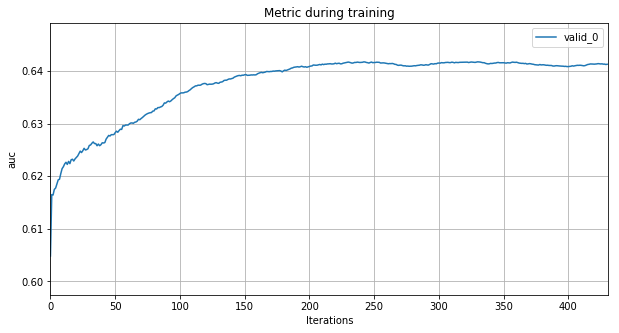

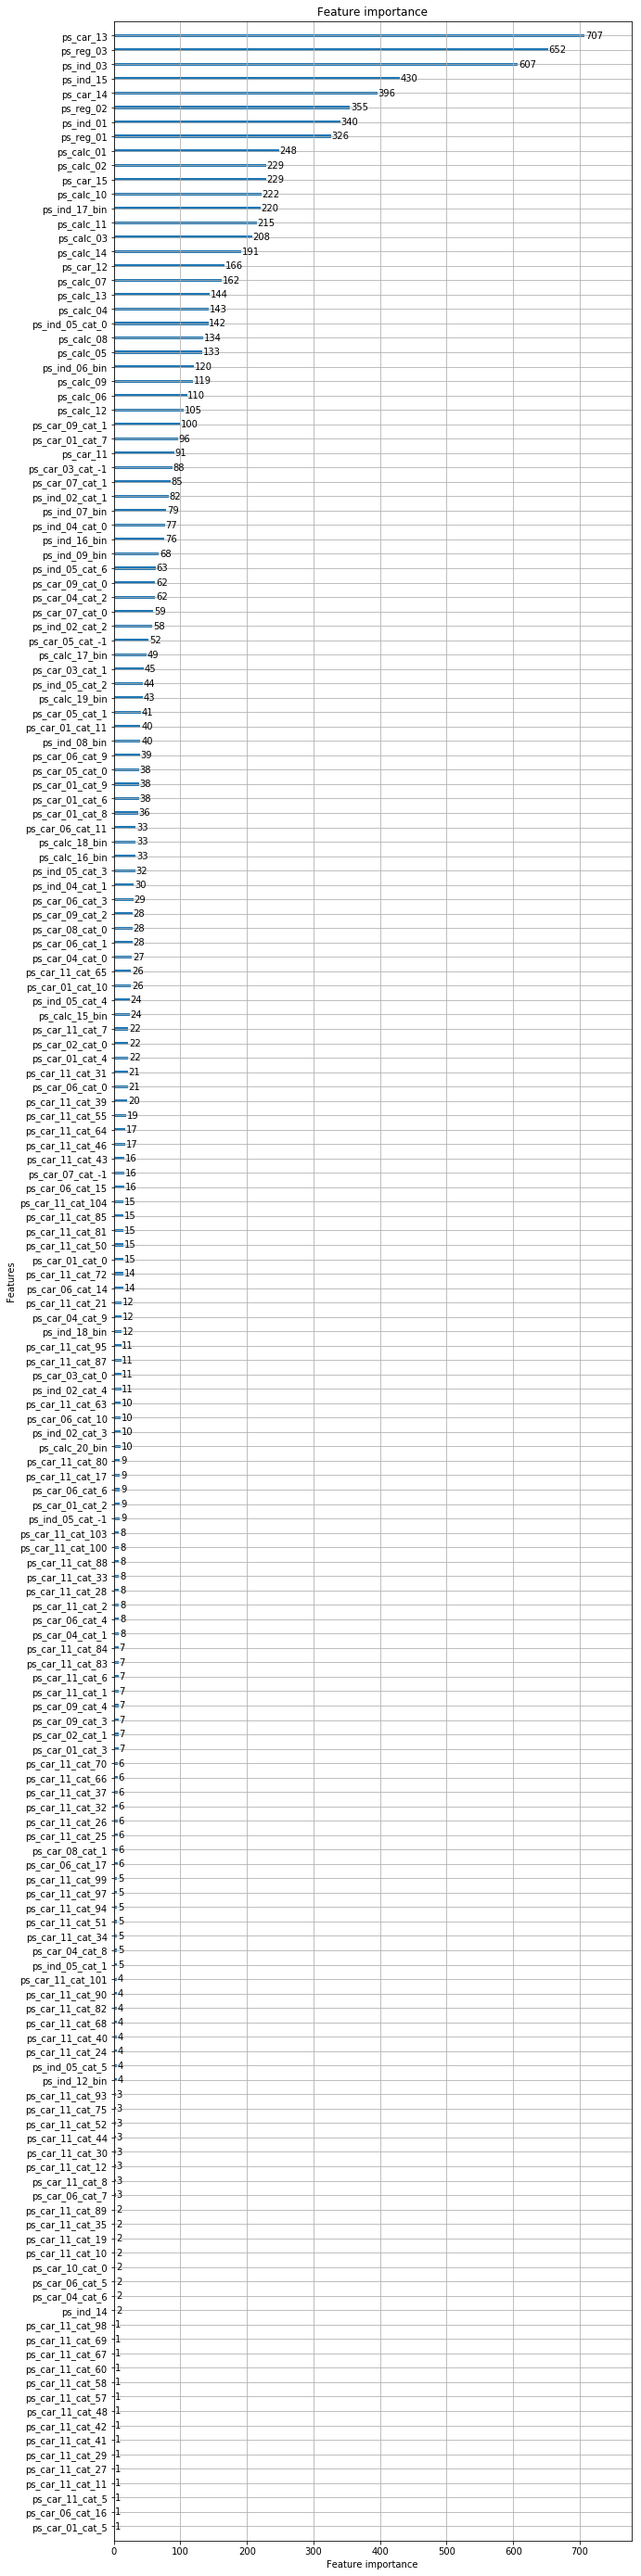

In [48]:
plt.rcParams["figure.figsize"] = (10,5)
lgb.plot_metric(evals_result)
plt.rcParams["figure.figsize"] = (10,50)
lgb.plot_importance(gbm)

In [49]:
# lgb.plot_tree(gbm, tree_index=0, figsize=(20, 25), show_info=['split_gain'])
graph = lgb.create_tree_digraph(gbm, tree_index=0)
graph


ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

## Keras

In [53]:
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = sub_xgb['target'] + sub_lgb['target']
sub.to_csv('sub.csv',index=False)